### Custom unitary gate approach (22 Jan)

See documentation at https://qiskit.org/documentation/tutorials/simulators/4_custom_gate_noise.html 
We now implement the unitary propagator operator U (derived from Kraus operator, time-dependent) as a Qiskit Operator block directly - no need to implement the layering ourselves. 

TODO: The issue now is that my computed U is not unitary.

In [2]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi
import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.tools.visualization import plot_histogram


### Propagator math

Any operator M can be decomposed into a Hermitian and anti-Hermitian component.

Definitions - Hermitian: $H^\dagger = H$ ; anti-Hermitian: $H^\dagger = -H$

Unitary matrix: $U^\dagger U = I$

$A = \frac{A + A^\dagger}{2} + \frac{A - A^\dagger}{2} = B + C$

Hermitian:
$B^\dagger = \frac{A^\dagger + A}{2} = B$

Anti-Hermitian:
$C^\dagger = \frac{A^\dagger - A}{2} = -C$

Propagator $U = 
\begin{pmatrix}
S_m & 0 & 0 & 0\\
0 & -S_p & 0 & 0\\
0 & 0 & -A_m & 0\\
0 & 0 & 0 & A_p
\end{pmatrix}
$

### Useful built-in functions
- matrix.transpose()
- matrix.getH() for conjugate transpose
- np.identity(N)
- matrix.item(i,j) to access (i,j) element of matrix object
- np.allclose(matrix1, matrix2)

In [9]:
# From eq. 13 of Schlimgen (2022) paper, at t = 0 
M = np.matrix(np.sqrt(0.5)*np.array([[1, 0],[0, 1]]))
print("Kraus operator M0(t=0):\n", M ,"\n")

# Compute Hermitian and anti-Hermitian parts
S = 0.5*(M + M.getH())   # conjugate transpose
A = 0.5*(M - M.getH())
print("Hermitian component S:\n", S, "\n")
print("Anti-Hermitian component A:\n", A, "\n")

Kraus operator M0(t=0):
 [[0.70710678 0.        ]
 [0.         0.70710678]] 

Hermitian component S:
 [[0.70710678 0.        ]
 [0.         0.70710678]] 

Anti-Hermitian component A:
 [[0. 0.]
 [0. 0.]] 



In [10]:
# Compute eq. 10 of Schmlingen (2022 paper)
epsilon = 0.0001   
Sm = 1j*np.exp(-1j*epsilon*S)     
Sp = (-Sm).getH()
Am = np.exp(-epsilon*A)
Ap = Am.getH()

print("Sm:\n", Sm )
print("Sp:\n", Sp)
print("Am:\n", Am)
print("Ap:\n", Ap)

Sm:
 [[7.07106781e-05+1.j 0.00000000e+00+1.j]
 [0.00000000e+00+1.j 7.07106781e-05+1.j]]
Sp:
 [[-7.07106781e-05+1.j -0.00000000e+00+1.j]
 [-0.00000000e+00+1.j -7.07106781e-05+1.j]]
Am:
 [[1. 1.]
 [1. 1.]]
Ap:
 [[1. 1.]
 [1. 1.]]


In [15]:
dim_M = len(M)   # 2
U = np.zeros((4*dim_M,4*dim_M),dtype = 'complex_')   # enable complex values

for i in range(dim_M):
    for j in range(dim_M):
        U[i][j] = Sm.item(i,j)
        U[i+dim_M][j+dim_M] = -Sp.item(i,j)
        U[i+2*dim_M][j+2*dim_M] = -Am.item(i,j)
        U[i+3*dim_M][j+3*dim_M] = Ap.item(i,j)
        
U = np.matrix(U)       # cast to matrix 
print("Propagator U:\n", np.round(U,5))

Propagator U:
 [[ 7.e-05+1.j  0.e+00+1.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j
   0.e+00+0.j  0.e+00+0.j]
 [ 0.e+00+1.j  7.e-05+1.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j
   0.e+00+0.j  0.e+00+0.j]
 [ 0.e+00+0.j  0.e+00+0.j  7.e-05-1.j  0.e+00-1.j  0.e+00+0.j  0.e+00+0.j
   0.e+00+0.j  0.e+00+0.j]
 [ 0.e+00+0.j  0.e+00+0.j  0.e+00-1.j  7.e-05-1.j  0.e+00+0.j  0.e+00+0.j
   0.e+00+0.j  0.e+00+0.j]
 [ 0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j -1.e+00+0.j -1.e+00+0.j
   0.e+00+0.j  0.e+00+0.j]
 [ 0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j -1.e+00+0.j -1.e+00+0.j
   0.e+00+0.j  0.e+00+0.j]
 [ 0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j
   1.e+00+0.j  1.e+00+0.j]
 [ 0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j  0.e+00+0.j
   1.e+00+0.j  1.e+00+0.j]]


In [16]:
I = np.identity(8)    # identity matrix

U_dg = U.getH()    # compute conjugate transpose
#print(U_dg)
print(U @ U_dg)

np.allclose(I, U@U_dg)

[[2.-3.58885134e-21j 2.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j]
 [2.+0.00000000e+00j 2.-3.58885134e-21j 0.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 2.+3.58885134e-21j
  2.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 2.+0.00000000e+00j
  2.+3.58885134e-21j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j 2.+0.00000000e+00j 2.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j 2.+0.00000000e+00j 2.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.0

False

### To do: fix unitary U? The current U U_dagger product looks like: 

$U = 
\begin{pmatrix}
2 & 2 & 0 & 0 & 0 & 0 & 0 & 0\\
2 & 2 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 2 & 2 & 0 & 0 & 0 & 0\\
0 & 0 & 2 & 2 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 2 & 2 & 0 & 0\\
0 & 0 & 0 & 0 & 2 & 2 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 2 & 2\\
0 & 0 & 0 & 0 & 0 & 0 & 2 & 2\\
\end{pmatrix}
$

instead of an 8x8 identity matrix. 

#### Example code

In [3]:
# Use Operator class in qiskit.quantum_info to represent arbitrary matrix operators
# Unitary operator can be added to quantum circuit simulation; here CNOT and iSWAP gate example

# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = qi.Operator([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = qi.Operator([[1, 0, 0, 0],
                        [0, 0, 1j, 0],
                        [0, 1j, 0, 0],
                        [0, 0, 0, 1]])

In [4]:
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = QuantumCircuit(2, name='cx<iSWAP>')

# Add gates
cx_circ.sdg(1)    
cx_circ.h(1)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.sdg(0)
cx_circ.h(0)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.s(1)      # S gate is pi/2 rotation around Z axis

cx_circ.draw("mpl")    # alternatively, print(cx_circ)
print("Example of a CNOT gate decomposed using single-qubit and iSWAP gates")

Example of a CNOT gate decomposed using single-qubit and iSWAP gates


In [5]:
# Simulate the unitary for the circuit using Operator:
unitary = qi.Operator(cx_circ)
print(unitary)
f_ave = qi.average_gate_fidelity(cx_op, unitary)
print("Average Gate Fidelity: F = {:f}".format(f_ave))

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Average Gate Fidelity: F = 1.000000


In [6]:
# AerSimulator can run arbitrary unitary operators specified by "unitary" in basis gates.
'unitary' in AerSimulator().configuration().basis_gates

True

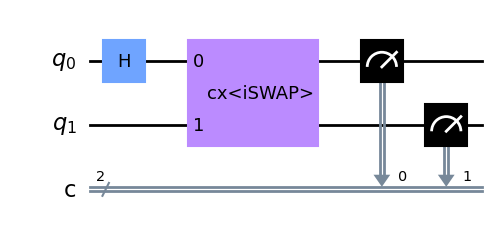

In [7]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(2, 2, name='bell')
bell_circ.h(0)
bell_circ.append(cx_circ, [0, 1])
bell_circ.measure([0,1], [0,1])

bell_circ.draw("mpl")    #print(bell_circ)

/Users/eugene/opt/miniconda3/envs/quantum/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/eugene/opt/miniconda3/envs/quantum/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


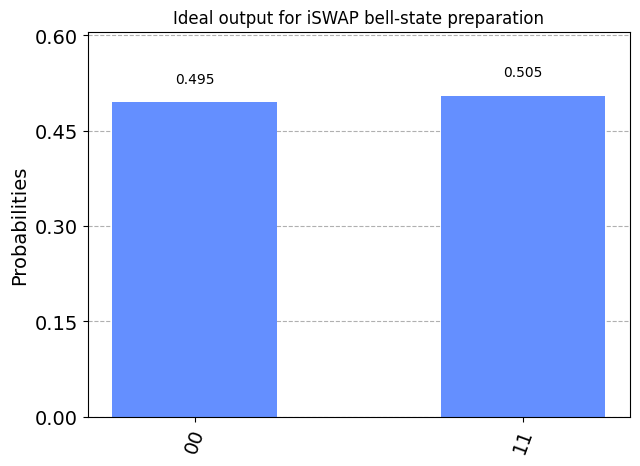

In [8]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
tbell_circ = transpile(bell_circ, sim_ideal)

ideal_result = sim_ideal.run(tbell_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for iSWAP bell-state preparation')

In [13]:
# end of code
import qiskit.tools.jupyter
%qiskit_version_table